Training DataLoader - First batch:
  Images batch shape: torch.Size([50, 1, 28, 28])
  Labels batch shape: torch.Size([50])
  Number of batches: 26
  Total number of items: 1257

Validation DataLoader - First batch:
  Images batch shape: torch.Size([50, 1, 28, 28])
  Labels batch shape: torch.Size([50])
  Number of batches: 6
  Total number of items: 269

Test DataLoader - First batch:
  Images batch shape: torch.Size([50, 1, 28, 28])
  Labels batch shape: torch.Size([50])
  Number of batches: 6
  Total number of items: 271

Epoch 1, Train Loss: 1.9165, Train Accuracy: 32.54%, Validation Loss: 0.7202, Validation Accuracy: 78.07%
Epoch 2, Train Loss: 0.6966, Train Accuracy: 76.37%, Validation Loss: 0.2670, Validation Accuracy: 89.59%
Epoch 3, Train Loss: 0.3542, Train Accuracy: 88.86%, Validation Loss: 0.1002, Validation Accuracy: 97.40%
Epoch 4, Train Loss: 0.2412, Train Accuracy: 92.52%, Validation Loss: 0.0949, Validation Accuracy: 96.65%
Epoch 5, Train Loss: 0.1994, Train Accuracy: 

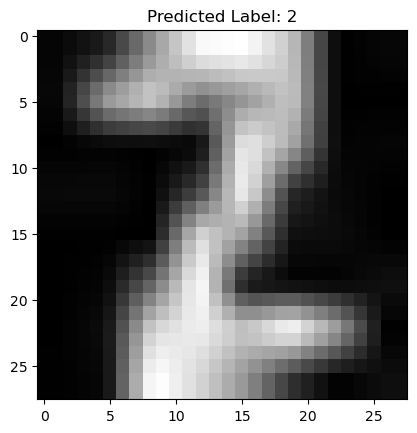

In [3]:
!pip install -r requirements.txt
import os 
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Compose , Resize , Lambda
import torch
import pandas as pd

class CustomMNISTDataset(Dataset):
    
    def __init__(self, img_dir, labels_file , transform=None , target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_labels = pd.read_csv(labels_file, sep=';',  names=['filename', 'label'] )
        
    
    def __len__(self):
        return len(self.img_labels)
   
    def __getitem__(self, idx):
        
        img_name = self.img_labels.iloc[idx, 0] 
        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path) 
          
        label = self.img_labels.iloc[idx, 1] 
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

transformations = Compose([
    Resize((28, 28)),  
     Lambda(lambda x: x.float() / 255.0), 
])

img_dir = 'mnist/data'
labels_file = 'mnist/target.txt'

dataset = CustomMNISTDataset(img_dir=img_dir, labels_file=labels_file, transform=transformations)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size


train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define the DataLoader instances right after splitting
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)

def check_dataloader_info(dataloader, dataloader_name):
    for i, (images, labels) in enumerate(dataloader):
        if i == 0:
            print(f"{dataloader_name} - First batch:")
            print(f"  Images batch shape: {images.shape}")
            print(f"  Labels batch shape: {labels.shape}")
            print(f"  Number of batches: {len(dataloader)}")
            print(f"  Total number of items: {len(dataloader.dataset)}\n")
        else:
            break

# Check information for each DataLoader
check_dataloader_info(train_dataloader, "Training DataLoader")
check_dataloader_info(val_dataloader, "Validation DataLoader")
check_dataloader_info(test_dataloader, "Test DataLoader")

import torch.nn as nn
import torch.nn.functional as F
import os
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
       
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)  
        #
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2) 
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7 * 7 * 64, 1024)  
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout()
    
    def forward(self, x):
    
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = x.view(-1, 7 * 7 * 64) 
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

model = CNN()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train() 
        train_running_loss, train_correct, train_total = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) 
            optimizer.zero_grad()  
            outputs = model(images) 
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step() 
            train_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_epoch_loss = train_running_loss / len(train_loader.dataset)
        train_epoch_accuracy = 100 * train_correct / train_total
        
        # Validation phase
        model.eval()  
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():  # No need to track gradients
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Move to device
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_accuracy = 100 * val_correct / val_total

        print(f"Epoch {epoch+1}, Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.2f}%, "
              f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%")

# Execute training and validation
train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device)



def test(model, test_loader, criterion, device):
    model.eval() 
    test_running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)  
            loss = criterion(outputs, labels) 
            test_running_loss += loss.item() * images.size(0)  
            _, predicted = torch.max(outputs.data, 1)  
            total_predictions += labels.size(0) 
            correct_predictions += (predicted == labels).sum().item()  
            
   
    avg_test_loss = test_running_loss / len(test_loader.dataset)
    test_accuracy = correct_predictions / total_predictions * 100  

   
    print(f'Total images in the test set: {len(test_loader.dataset)}')
    print(f'Average test loss: {avg_test_loss:.4f}')
    print(f'Test accuracy: {test_accuracy:.2f}%')


print("Evaluating on test dataset...")
test(model, test_dataloader, criterion, device)


def check_dataloader_info(dataloader, dataloader_name):
    
    for i, (images, labels) in enumerate(dataloader):
        
        if i == 0:
            print(f"{dataloader_name} - First batch:")
            print(f"  Images batch shape: {images.shape}")
            print(f"  Labels batch shape: {labels.shape}")
            print(f"  Number of batches: {len(dataloader)}")
            print(f"  Total number of items: {len(dataloader.dataset)}\n")
        else:
           
            break


print("Evaluating on test dataset...")
test(model, test_dataloader, criterion, device)

import matplotlib.pyplot as plt


model.eval()

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)


images, labels = next(iter(test_dataloader))

# Choose a single image from the batch
image, label = images[0], labels[0]


image = image.unsqueeze(0).to(device)


output = model(image)

# Get the prediction
prediction = output.argmax(dim=1, keepdim=True).item()

print(f"Prediction: {prediction}")


image = image.squeeze(0).squeeze(0).cpu().numpy()

# Visualize the image
plt.imshow(image, cmap='gray')
plt.title(f'Predicted Label: {prediction}')
plt.show()





Prediction: 9


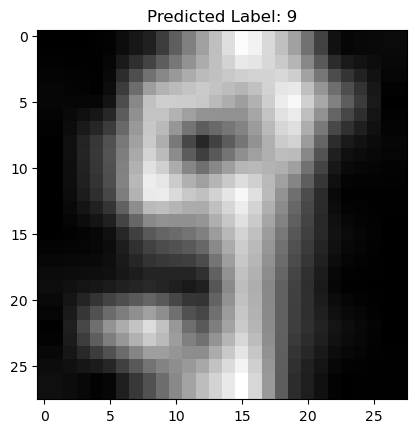

In [6]:

import matplotlib.pyplot as plt


model.eval()

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)


images, labels = next(iter(test_dataloader))

# Choose a single image from the batch
image, label = images[0], labels[0]


image = image.unsqueeze(0).to(device)


output = model(image)

# Get the prediction
prediction = output.argmax(dim=1, keepdim=True).item()

print(f"Prediction: {prediction}")


image = image.squeeze(0).squeeze(0).cpu().numpy()

# Visualize the image
plt.imshow(image, cmap='gray')
plt.title(f'Predicted Label: {prediction}')
plt.show()

